In [1]:
#Import relevant Classes!
import numpy as np
import copy
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
from gzip import compress, decompress
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input 
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.decomposition import IncrementalPCA
import sys
!{sys.executable} -m pip install kneed
from kneed import KneeLocator
from shapely.wkt import loads
import random
from tqdm.notebook import tqdm
sys.path.append('../Predicted_Datasets/')
import itertools
import PIL
import requests
import io
from PIL import Image
from requests.adapters import HTTPAdapter, Retry
import pyproj
import shapely

from shapely.ops import transform
import ee
#ee.Authenticate()
ee.Initialize()
import geetools
from tifffile import imread, imwrite
import zipfile
import os
import shutil
import googlemaps
import keys
from googlemaps.maps import StaticMapPath
gmaps=googlemaps.Client(key=keys.googleMapsKey)

2022-12-13 16:51:10.769032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 16:51:11.283995: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 16:51:11.284010: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 16:51:12.742173: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
def loadImage(image,geometry,rgb_only=True):
    
    #save image locally as three separate tif files zipped
    if rgb_only:
        bands=['B4','B3','B2']
    else:
        bands=['B1','B4','B3','B2','B5','B7','B8A','B8','B11','B12']
    try:
        thumbUrl=image.getThumbUrl({
            'region':geometry,
            'bands':bands,
            'min':0,
            'max':3000,
            'format':'png',
            'crs':'EPSG:3857',
            'dimensions':'64x64',
        })
        #"""
        s = requests.Session()
        retries = Retry(
            total=1,
            backoff_factor=0.1,
            status_forcelist=[429, 500, 502, 503, 504]
        )

        s.mount(thumbUrl, HTTPAdapter(max_retries=retries))

        response = s.get(thumbUrl,timeout=15)
        img = Image.open(io.BytesIO(response.content)).convert('RGB')
        img = np.array(img)
        if img.shape != (64,64,3):
            return None
    except ee.EEException as e:
        print("Earth Engine Failure",e)
        return None
    except PIL.UnidentifiedImageError as p:
        print(response.content)
        return None
    except Exception as e:
        print(e)
        return None
    #"""
    #the stack to make an int array cutting off any extra rows/columns to guarantee shape
    img=img[:64,:64,:]
    #Delete Temporary Files and return img
    return img

In [3]:
def transformCoordinates(geometry,sourceCoord,toCoord):
    #Initialize Coord Swapping
    source = pyproj.CRS(sourceCoord)
    to = pyproj.CRS(toCoord)
    project = pyproj.Transformer.from_crs(source, to, always_xy=True).transform
    
    #Create usable format for geometry and transform it
    shapegeom=shapely.geometry.shape(eval(geometry)['geometry'])
    transformedgeom = transform(project, shapegeom)
    
    #Get center of tile
    center=transformedgeom.centroid
    
    #Get coordinates of the transformed tile
    coordlist=[]
    xcoord,ycoord=transformedgeom.exterior.coords.xy
    for i in range(len(xcoord)):
        coordlist.append({"lat":ycoord[i],"lng":xcoord[i]})
        
    return center,coordlist

In [4]:
#Create extract_features function which takes the image and retrieves features from the vgg model
def extract_features(img,model):
    reshaped_img=img.reshape(1,LOWIMGSHAPE,LOWIMGSHAPE,3)
    copied=copy.deepcopy(reshaped_img)
    imgx=preprocess_input(reshaped_img)
    features=model.predict(imgx,use_multiprocessing=False,verbose=0)
    return features

In [5]:
#Create gethrimage function which tries to obtain the satellite imagery of s2 and ab as uint8 arrays scaled to 0-255 for future plts, limited to TIMEOUT time in seconds.
def gethrimage(subtileGeometries):
    idx=subtileGeometries[0][0]
    geometry=subtileGeometries[0][1]
    lowResCollection=subtileGeometries[1]
    
    #Load google ee image
    collection=lowResCollection.filterBounds(ee.Geometry(eval(geometry)['geometry'])).filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE',25)).filter(ee.Filter.lte('DARK_FEATURES_PERCENTAGE',25)).filter(ee.Filter.lte('THIN_CIRRUS_PERCENTAGE',25))
    image=collection.sort('HIGH_PROBA_CLOUDS_PERCENTAGE').first().clip(ee.Geometry(eval(geometry)['geometry']))
    lowImg=loadImage(image,eval(geometry)['geometry'])
    if lowImg is None:
        print('None or bad image shape returned')
        return None
    
    #Load google maps static image
    center,coordlist=transformCoordinates(geometry,sourceCoord='EPSG:3857',toCoord='EPSG:4326')
    path=StaticMapPath(
        points=coordlist,
        weight=5,
        color="red",
        geodesic=True,
    )
    try:
        response = gmaps.static_map(
            size=(640,640),
            zoom=17,
            center=(center.y,center.x),
            maptype='satellite',
            format='png',
            scale='1',   
            path=path,
        )
        
        temp=b''.join(list(response))
        image=np.array(Image.open(io.BytesIO(temp)).convert('RGB'))
    except:
        return None
    return [str(idx),lowImg,image,geometry,center]

In [6]:
#Set a number of global parameters for the entire form, edit this to specifications
#Size of input image for the vggmodel initialization
LOWIMGSHAPE=64
#Number of images to be put into the Kmeans algorithm.  Active memory limited to 2500 with a pair of 64*64*3 and 640*640*3 satellite images and a feature set of 2*2*512, test or adjust at will
BATCHSIZE=2250
#Maximum number of groups to separate images into during the kmeans step.  Usually between 5-10 but this depends on input image and the feature extraction process, test or adjust at will 
KMEANSSIZE=50
#Name of the current dataset, change as needed
datasetName='googletest_state_sampled_slender_panda'
#File Path
pathway='Temp Images/'+datasetName+'/'

In [7]:
def InitiateModel(subtileGeometries,batch):
    #Initialize image dictionaries with keys and None
    imageDict={}
    data={}
    for pair in subtileGeometries:
        imageDict[pair[0]]=None
    hrImgDict=copy.deepcopy(imageDict)
    
    #Initialize satellites
    lowResCollection=ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterDate('2020-09-01','2021-09-01')
    
    #Initialize model
    model = VGG16(include_top=False,input_shape=(LOWIMGSHAPE,LOWIMGSHAPE,3))
    model = Model(inputs = model.inputs, outputs = model.layers[-1].output)
    
    #Get all of the low res images using some threadpooling and extract features from the VGG model
    print('Getting Images!') 
    with Pool(processes=25) as pool:
        with tqdm(total=len(subtileGeometries)) as pbar:
            for task in pool.imap_unordered(gethrimage, zip(subtileGeometries,itertools.repeat(lowResCollection,len(subtileGeometries)))):
                if task is not None:
                    idx=task[0]
                    lowImg=task[1]
                    img=task[2]
                    geometry=task[3]
                    center=task[4]
                    data[idx]=extract_features(lowImg,model)
                    imageDict[idx]=[lowImg,geometry,center]
                    hrImgDict[idx]=[img,geometry,center]
                pbar.update()
    print('Done!')
    
    #Upload the batch of images to the storage for later retrieval and clear the dictionaries
    print('Saving Image Dicts to Files!')
    loFile=open(pathway+datasetName+'LrBatch'+str(batch),'wb')
    hrFile=open(pathway+datasetName+'HrBatch'+str(batch),'wb')
    pkl.dump(imageDict,loFile)
    pkl.dump(hrImgDict,hrFile)
    imageDict.clear()
    hrImgDict.clear()
            
    #initiate and run kmeans on a transformed feature set
    feat = np.array(list(data.values()))
    feat = feat.reshape(-1,2048)
    if feat.shape[0] < 20:
        print('Not enough images processed, please check the api usages and errors to ensure enough data is being processed')
        return None
    #Optimize the number of reduced features for groupings and run a final time on the most optimal
    print("Optimizing Features")
    pca = IncrementalPCA(n_components=20,batch_size=20)
    pca.fit(feat)
    varianceDiff = [x - pca.explained_variance_ratio_[i - 1] for i, x in enumerate(pca.explained_variance_ratio_)][1:]
    minVarianceIndex=varianceDiff.index(min(varianceDiff))+1

    pca = IncrementalPCA(n_components=minVarianceIndex,batch_size=20)
    pca.fit(feat)
    
    x=pca.transform(feat)
    feat=[]
    inertia=[]
    
    #Optimize Kmeans grouping by running it over a range of groups and run a final time on the most optimal
    print("Optimizing clusters")
    for y in range(1,KMEANSSIZE):
        kmeans=KMeans(n_clusters=y)
        kmeans.fit(x)
        inertia.append(kmeans.inertia_)
        
    plt.plot(range(1,KMEANSSIZE),inertia,'-o',color='black')
    
    kl = KneeLocator(range(1,KMEANSSIZE), inertia,direction='decreasing', curve="convex")
    kl.plot_knee()
    
    kmeans=KMeans(n_clusters=kl.knee)
    kmeans.fit(x)
    
    
    #Create Cluster Groups from KMeans results
    print("Creating groups!")
    groups={}
    for key, cluster in zip(np.array(list(data.keys())),kmeans.labels_):
        if str(cluster) not in groups.keys():
            groups[str(cluster)]=[]
            groups[str(cluster)].append(key)
        else:
            groups[str(cluster)].append(key)
    
    #Upload the final grouping of the batch
    print("Uploading Batched Group to Storage!")
    groupFile=open(pathway+datasetName+'GroupBatch'+str(batch),'wb')
    pkl.dump(groups,groupFile)
    #storage.set(datasetName+'GroupBatch'+str(batch),compress(pkl.dumps(groups)))


## Look over these next cells and edit/change or initialize any necessary values

In [8]:
#Load model results and separate the test set
if not os.path.exists('Temp Images/'+datasetName):
    os.mkdir('Temp Images/'+datasetName)
totalDataset=pd.read_csv('../Predicted_Datasets/'+datasetName+'_results.csv').to_dict()
subtileGeometries=[]
for keys in totalDataset['prediction']:
    subtileGeometries.append([totalDataset['idx'][keys],totalDataset['geometry'][keys]])
random.shuffle(subtileGeometries)
totalDataset.clear()

In [9]:
#Create number of batches by set BATCHSIZE
print(len(subtileGeometries))
batches = math.ceil(len(subtileGeometries)/BATCHSIZE)

1221


## !!!
## BEWARE RUNNING THE NEXT CELL WILL OVERWRITE EXISTING DATA IN STORAGE WITH THE SAME DATANAME, ENSURE THE:
## DATANAME GLOBAL ABOVE IS ACCURATE
## THE INFORMATION THERE IS NOT NECESSARY
## REDUNDANCIES EXIST
## THE BATCHES ARE STARTING FROM THE NEXT UNSAVED POINT
## !!!

In [10]:
model = VGG16(include_top=False,input_shape=(LOWIMGSHAPE,LOWIMGSHAPE,3))
model = Model(inputs = model.inputs, outputs = model.layers[-1].output)

2022-12-13 16:51:33.180784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-13 16:51:33.180916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 16:51:33.180983: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-13 16:51:33.181026: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-13 16:51:33.181067: W tensorf

In [11]:
#eat the first crash TODO: Fix initial batch rejection
print("Face Tanking Initial Batch of Errors Please Ignore")
InitiateModel(subtileGeometries[:25],0)

Face Tanking Initial Batch of Errors Please Ignore
Getting Images!


  0%|          | 0/25 [00:00<?, ?it/s]

('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

None or bad image shape returned('Connection aborted.', RemoteDisconnected('R

Batch # 0  of  0 


Getting Images!


  0%|          | 0/1221 [00:00<?, ?it/s]

Done!
Saving Image Dicts to Files!
Optimizing Features
Optimizing clusters
Creating groups!
Uploading Batched Group to Storage!


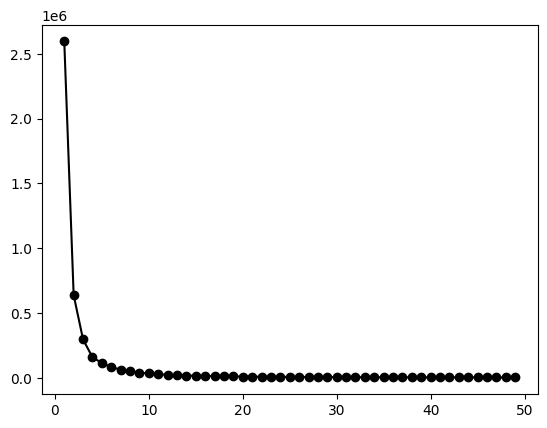

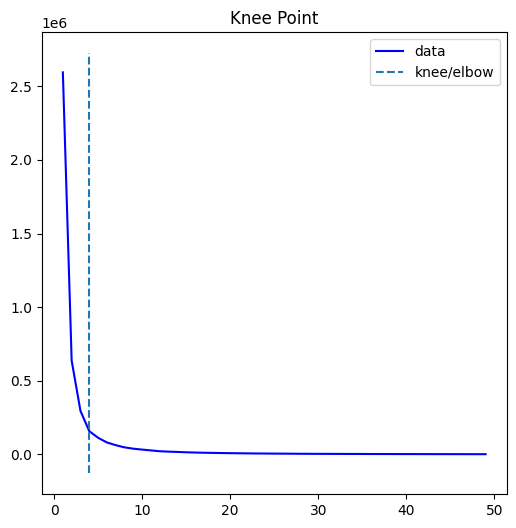

In [12]:
#Iterate through each batch of BATCHSIZE and Initiate and upload the groupings
for batch in range(0,batches):
    print("Batch #",batch," of ", batches-1, "\n\n")
    InitiateModel(subtileGeometries[batch*BATCHSIZE:(batch+1)*BATCHSIZE],batch)

In [13]:
print('hi')

hi
